In [1]:
shape_cat=""
vol=""
z_range=""
key=""
quantile=""
test=""
z_diff=""

In [2]:
# Parameters
shape_cat = "mcal"
vol = "uber"
z_range = "all_z"
key = ""
quantile = ""
test = "background"
z_diff = 0.5


In [3]:
#This header file contains all the common packages
%matplotlib inline
%run /home/cz136/project/sa/lib/src/header.py $shape_cat $vol $z_range 
%run -i /home/cz136/project/sa/lib/src/func.py  

In [4]:
z_diff=float(z_diff)

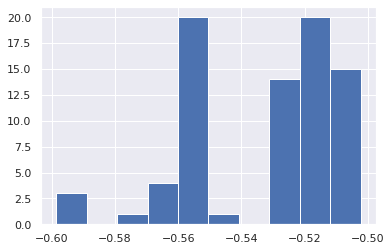

In [5]:
if test=="foreground":
    members=shapes[(shapes[('All','Z')]-shapes[('All','ZRED2')])>=z_diff]
    diff=members[('All','Z')]-members[('All','ZRED2')]
    diff.hist()
    diff.describe()
    
elif test=="background":
    members=background=shapes[(shapes[('All','Z')]-shapes[('All','ZRED2')])<=-z_diff]
    diff=members[('All','Z')]-members[('All','ZRED2')]
    diff.hist()
    diff.describe()
elif test=="":
    members=shapes
else:
    raise TypeError

In [6]:
if vol!="uber":
    members=shapes

In [7]:
if quantile!="":
    i=int(quantile)

In [8]:
if key=="lambda":
    key=('All','All','LAMBDA_CHISQ')
elif key=="z":
    key=('All','All','Z_LAMBDA')

In [9]:
def thirds_by_key(catalog,key):
    step0=catalog[key].quantile(0.0)
    step1=catalog[key].quantile(0.333333)
    step2=catalog[key].quantile(0.666666)
    step3=catalog[key].quantile(1)
    
    catalog1=catalog[(catalog[key]>step0) & (catalog[key]<step1)]
    catalog2=catalog[(catalog[key]>step1) & (catalog[key]<step2)]
    catalog3=catalog[(catalog[key]>step2) & (catalog[key]<step3)]
    
    return (catalog1,catalog2,catalog3)

In [10]:
if key!="":
    clusters_list=thirds_by_key(clusters,key)
    clusters=clusters_list[i]

In [11]:
sep="------------------------------------------------------------------------------"
np.set_printoptions(precision=4)

In [12]:
NBINS=10

In [13]:
import treecorr
import astropy.cosmology
from fastprogress import master_bar, progress_bar
from ipywidgets import FloatProgress
from IPython.display import display
from tqdm import tqdm

In [14]:
len(shapes)

1079244

In [15]:
len(members)

78

In [16]:
if key=="":
    assert np.isin(shapes['All','MEM_MATCH_ID'].to_numpy(),clusters.index.to_numpy()).all()==True

In [17]:
def get_ng(cluster,mode1,mode2):
    if mode2=="abs":
        UPPER_BOUND=np.max(shapes[('All','R')])
        distance=('All','angR')
        
    elif mode2=="rel":
        UPPER_BOUND=1.2
        distance=('All','normLR')
    else:
        raise

    if mode1 == "s":
        def get_cluster_cen(cluster):
            return (get_unique_center_for_cluster(cluster))
        def get_cluster_sats(cluster):
            cen_mat_id=cluster.name
            cen_id=cluster[('Alt','Alt1','ID_CENT')]
            sats=members[members['All','MEM_MATCH_ID']==cen_mat_id]
            sats=sats[sats.index!=cen_id]
            return (sats)
    elif mode1=='r':
        def get_cluster_sats(cluster):
            return(shapes)
        def get_cluster_cen(cluster):
            return (random)

    else:
        raise


    cen=get_cluster_cen(cluster)
    sats=get_cluster_sats(cluster)


    sats_e1=sats[('All','e1')].to_numpy()
    sats_e2=sats[('All','e2')].to_numpy()
    sats_angr=sats[distance]

#     print(sats_e1,sats_e2)

    if type(cen[('All','RA')])==np.float64:
        cen_angr=np.array(cen[distance]).reshape(1)
        cen_ra=np.array(cen[('All','RA')]).reshape(1)
        cen_dec=np.array(cen[('All','DEC')]).reshape(1)
    else:
#         cen_e1=cen[('All','e1')].to_numpy
#         cen_e2=cen[('All','e2')].to_numpy()
        cen_angr=cen[distance].to_numpy()
        cen_ra=cen[('All','RA')].to_numpy()
        cen_dec=cen[('All','DEC')].to_numpy()




#     print(cen_e1,cen_e2)

    sats_ra=sats[('All','RA')].to_numpy()
    sats_dec=sats[('All','DEC')].to_numpy()




#     print(np.shape(cen_ra),np.shape(cen_dec))    
#     print(cen_ra,cen_dec)    

    sats_cat = treecorr.Catalog( g1 = sats_e1, g2   = sats_e2, 
                                 ra = sats_ra, dec = sats_dec,r=sats_angr,
                                 ra_units='deg', dec_units='deg')

    cen_cat = treecorr.Catalog( 
                                 ra = cen_ra, dec = cen_dec, r=cen_angr,
                                 ra_units='deg', dec_units='deg')

    ng = treecorr.NGCorrelation(nbins=NBINS, min_sep=0.01, max_sep=UPPER_BOUND, bin_slop=0.0,
                               metric="Rperp")
    ng.process_cross(cen_cat,sats_cat)

    return(ng)

In [18]:
def get_xi_meanlogr_varxi_npairs(cluster,mode1,mode2):
    ng=get_ng(cluster,mode1,mode2)
    return(np.array([ng.xi,ng.meanlogr,ng.varxi,ng.npairs]))

In [19]:
length=len(clusters)

def get_ng_list(mode2):
    ng_list=np.empty([length,4,NBINS])
    filler=np.zeros([1,4,NBINS])

    i=0
    e_count=0
    for index,cluster in tqdm(clusters.iterrows()):
        try:
            ng_list[i,:,:]=get_xi_meanlogr_varxi_npairs(cluster,'s',mode2)
            i=i+1
        except ValueError as e:
            ng_list[i,:,:]=filler
            i=i+1
            e_count=e_count+1
    print("Number of empty sat catalogs is {}".format(e_count))
    return (ng_list)

In [20]:
ng_abs=get_ng_list('abs')
ng_rel=get_ng_list('rel')

0it [00:00, ?it/s]

6it [00:00, 58.15it/s]

18it [00:00, 68.29it/s]

31it [00:00, 78.99it/s]

44it [00:00, 88.36it/s]

57it [00:00, 96.10it/s]

70it [00:00, 102.73it/s]

83it [00:00, 107.43it/s]

96it [00:00, 111.56it/s]

109it [00:00, 114.90it/s]

122it [00:01, 116.46it/s]

135it [00:01, 117.29it/s]

148it [00:01, 119.08it/s]

161it [00:01, 121.00it/s]

174it [00:01, 121.85it/s]

187it [00:01, 120.87it/s]

200it [00:01, 120.06it/s]

213it [00:01, 119.60it/s]

225it [00:01, 119.40it/s]

237it [00:02, 119.55it/s]

249it [00:02, 118.95it/s]

261it [00:02, 119.04it/s]

273it [00:02, 119.04it/s]

285it [00:02, 118.97it/s]

297it [00:02, 118.80it/s]

309it [00:02, 119.03it/s]

321it [00:02, 118.64it/s]

333it [00:02, 118.43it/s]

345it [00:02, 118.77it/s]

358it [00:03, 119.94it/s]

371it [00:03, 120.45it/s]

384it [00:03, 120.77it/s]

397it [00:03, 121.18it/s]

410it [00:03, 118.03it/s]

422it [00:03, 117.14it/s]

435it [00:03, 118.10it/s]

448it [00:03, 119.31it/s]

461it [00:03, 119.63it/s]

474it [00:03, 120.40it/s]

487it [00:04, 120.48it/s]

500it [00:04, 120.59it/s]

513it [00:04, 120.28it/s]

526it [00:04, 120.56it/s]

539it [00:04, 120.57it/s]

552it [00:04, 120.71it/s]

565it [00:04, 121.02it/s]

578it [00:04, 120.72it/s]

591it [00:04, 120.70it/s]

604it [00:05, 120.71it/s]

617it [00:05, 120.51it/s]

630it [00:05, 120.41it/s]

643it [00:05, 120.65it/s]

656it [00:05, 120.57it/s]

669it [00:05, 120.67it/s]

682it [00:05, 120.48it/s]

695it [00:05, 120.53it/s]

708it [00:05, 120.47it/s]

721it [00:06, 120.66it/s]

734it [00:06, 120.88it/s]

747it [00:06, 121.58it/s]

760it [00:06, 121.67it/s]

773it [00:06, 121.27it/s]

786it [00:06, 121.17it/s]

799it [00:06, 121.87it/s]

812it [00:06, 121.71it/s]

825it [00:06, 121.96it/s]

838it [00:07, 120.50it/s]

851it [00:07, 108.88it/s]

863it [00:07, 107.52it/s]

876it [00:07, 112.03it/s]

889it [00:07, 115.57it/s]

902it [00:07, 118.22it/s]

915it [00:07, 119.13it/s]

928it [00:07, 119.69it/s]

941it [00:07, 119.93it/s]

954it [00:08, 114.87it/s]

966it [00:08, 107.81it/s]

977it [00:08, 103.28it/s]

988it [00:08, 100.45it/s]

999it [00:08, 102.70it/s]

1011it [00:08, 107.18it/s]

1022it [00:08, 107.10it/s]

1035it [00:08, 110.90it/s]

1047it [00:08, 112.32it/s]

1060it [00:09, 115.39it/s]

1073it [00:09, 118.35it/s]

1086it [00:09, 119.86it/s]

1099it [00:09, 120.75it/s]

1112it [00:09, 121.65it/s]

1125it [00:09, 121.83it/s]

1138it [00:09, 122.03it/s]

1151it [00:09, 121.86it/s]

1164it [00:09, 121.93it/s]

1177it [00:09, 122.24it/s]

1190it [00:10, 122.99it/s]

1203it [00:10, 122.88it/s]

1216it [00:10, 122.95it/s]

1229it [00:10, 123.47it/s]

1242it [00:10, 123.92it/s]

1255it [00:10, 123.77it/s]

1268it [00:10, 123.91it/s]

1281it [00:10, 123.07it/s]

1294it [00:10, 122.44it/s]

1307it [00:11, 121.79it/s]

1320it [00:11, 121.60it/s]

1333it [00:11, 121.36it/s]

1346it [00:11, 121.37it/s]

1359it [00:11, 121.26it/s]

1372it [00:11, 121.34it/s]

1385it [00:11, 120.88it/s]

1398it [00:11, 120.95it/s]

1411it [00:11, 121.37it/s]

1424it [00:11, 121.76it/s]

1437it [00:12, 122.04it/s]

1450it [00:12, 121.94it/s]

1463it [00:12, 121.58it/s]

1476it [00:12, 121.25it/s]

1489it [00:12, 121.62it/s]

1502it [00:12, 121.22it/s]

1515it [00:12, 121.26it/s]

1528it [00:12, 121.21it/s]

1541it [00:12, 120.54it/s]

1554it [00:13, 120.49it/s]

1567it [00:13, 120.76it/s]

1580it [00:13, 121.02it/s]

1593it [00:13, 121.25it/s]

1606it [00:13, 121.24it/s]

1619it [00:13, 121.20it/s]

1632it [00:13, 121.73it/s]

1645it [00:13, 122.46it/s]

1658it [00:13, 122.77it/s]

1671it [00:14, 122.99it/s]

1684it [00:14, 123.01it/s]

1697it [00:14, 122.35it/s]

1710it [00:14, 121.84it/s]

1723it [00:14, 121.39it/s]

1736it [00:14, 121.23it/s]

1749it [00:14, 121.12it/s]

1762it [00:14, 120.85it/s]

1775it [00:14, 120.77it/s]

1788it [00:14, 120.84it/s]

1801it [00:15, 121.00it/s]

1814it [00:15, 120.90it/s]

1827it [00:15, 121.12it/s]

1840it [00:15, 120.94it/s]

1853it [00:15, 121.29it/s]

1866it [00:15, 121.12it/s]

1879it [00:15, 121.35it/s]

1892it [00:15, 121.51it/s]

1905it [00:15, 121.07it/s]

1918it [00:16, 120.99it/s]

1931it [00:16, 121.21it/s]

1944it [00:16, 120.91it/s]

1957it [00:16, 120.98it/s]

1970it [00:16, 121.08it/s]

1983it [00:16, 121.24it/s]

1996it [00:16, 121.52it/s]

2009it [00:16, 121.68it/s]

2022it [00:16, 121.54it/s]

2035it [00:17, 121.61it/s]

2048it [00:17, 121.57it/s]

2061it [00:17, 121.36it/s]

2074it [00:17, 121.45it/s]

2087it [00:17, 121.75it/s]

2100it [00:17, 121.72it/s]

2113it [00:17, 121.34it/s]

2126it [00:17, 121.42it/s]

2139it [00:17, 121.40it/s]

2152it [00:17, 121.41it/s]

2165it [00:18, 121.56it/s]

2178it [00:18, 121.57it/s]

2191it [00:18, 121.03it/s]

2204it [00:18, 120.95it/s]

2217it [00:18, 120.92it/s]

2230it [00:18, 120.71it/s]

2243it [00:18, 120.41it/s]

2256it [00:18, 120.67it/s]

2269it [00:18, 120.65it/s]

2282it [00:19, 120.60it/s]

2295it [00:19, 120.45it/s]

2308it [00:19, 120.75it/s]

2321it [00:19, 120.51it/s]

2334it [00:19, 120.69it/s]

2347it [00:19, 121.07it/s]

2360it [00:19, 120.98it/s]

2373it [00:19, 120.94it/s]

2386it [00:19, 120.88it/s]

2399it [00:20, 120.93it/s]

2412it [00:20, 121.37it/s]

2425it [00:20, 121.10it/s]

2438it [00:20, 121.24it/s]

2451it [00:20, 121.32it/s]

2464it [00:20, 121.42it/s]

2477it [00:20, 121.25it/s]

2490it [00:20, 120.93it/s]

2503it [00:20, 121.00it/s]

2516it [00:20, 121.02it/s]

2529it [00:21, 121.05it/s]

2542it [00:21, 121.44it/s]

2555it [00:21, 121.49it/s]

2568it [00:21, 120.98it/s]

2581it [00:21, 121.02it/s]

2594it [00:21, 121.31it/s]

2607it [00:21, 120.92it/s]

2620it [00:21, 121.94it/s]

2633it [00:21, 121.57it/s]

2646it [00:22, 121.73it/s]

2659it [00:22, 122.53it/s]

2672it [00:22, 121.81it/s]

2685it [00:22, 122.27it/s]

2698it [00:22, 121.63it/s]

2711it [00:22, 121.54it/s]

2724it [00:22, 121.28it/s]

2737it [00:22, 121.08it/s]

2750it [00:22, 121.27it/s]

2763it [00:23, 121.16it/s]

2776it [00:23, 120.82it/s]

2789it [00:23, 120.98it/s]

2802it [00:23, 121.16it/s]

2815it [00:23, 120.80it/s]

2828it [00:23, 121.27it/s]

2841it [00:23, 121.10it/s]

2854it [00:23, 120.98it/s]

2867it [00:23, 121.07it/s]

2880it [00:23, 121.47it/s]

2893it [00:24, 121.78it/s]

2906it [00:24, 121.72it/s]

2919it [00:24, 121.83it/s]

2932it [00:24, 121.50it/s]

2945it [00:24, 121.07it/s]

2958it [00:24, 120.43it/s]

2971it [00:24, 120.42it/s]

2984it [00:24, 120.83it/s]

2997it [00:24, 120.72it/s]

3010it [00:25, 120.81it/s]

3023it [00:25, 120.74it/s]

3036it [00:25, 121.17it/s]

3049it [00:25, 120.63it/s]

3062it [00:25, 121.26it/s]

3075it [00:25, 121.27it/s]

3088it [00:25, 121.51it/s]

3101it [00:25, 121.20it/s]

3114it [00:25, 120.85it/s]

3127it [00:26, 120.39it/s]

3140it [00:26, 120.83it/s]

3153it [00:26, 120.94it/s]

3166it [00:26, 121.02it/s]

3179it [00:26, 121.24it/s]

3192it [00:26, 121.32it/s]

3205it [00:26, 121.08it/s]

3218it [00:26, 120.66it/s]

3231it [00:26, 120.51it/s]

3244it [00:27, 120.50it/s]

3257it [00:27, 120.63it/s]

3270it [00:27, 121.05it/s]

3283it [00:27, 121.04it/s]

3296it [00:27, 121.09it/s]

3309it [00:27, 120.92it/s]

3322it [00:27, 120.97it/s]

3335it [00:27, 121.39it/s]

3348it [00:27, 121.27it/s]

3361it [00:27, 121.19it/s]

3374it [00:28, 121.03it/s]

3387it [00:28, 121.27it/s]

3400it [00:28, 121.42it/s]

3413it [00:28, 121.48it/s]

3426it [00:28, 121.66it/s]

3439it [00:28, 121.03it/s]

3452it [00:28, 121.81it/s]

3465it [00:28, 122.40it/s]

3478it [00:28, 122.25it/s]

3491it [00:29, 122.72it/s]

3504it [00:29, 123.15it/s]

3517it [00:29, 123.51it/s]

3530it [00:29, 123.96it/s]

3543it [00:29, 123.67it/s]

3556it [00:29, 123.18it/s]

3569it [00:29, 123.46it/s]

3582it [00:29, 122.98it/s]

3595it [00:29, 123.72it/s]

3608it [00:29, 123.50it/s]

3621it [00:30, 121.79it/s]

3634it [00:30, 110.84it/s]

3646it [00:30, 104.63it/s]

3657it [00:30, 100.19it/s]

3668it [00:30, 97.26it/s] 

3678it [00:30, 95.93it/s]

3688it [00:30, 94.85it/s]

3698it [00:30, 94.15it/s]

3710it [00:31, 100.09it/s]

3723it [00:31, 105.70it/s]

3736it [00:31, 109.82it/s]

3749it [00:31, 113.10it/s]

3762it [00:31, 115.45it/s]

3775it [00:31, 117.17it/s]

3788it [00:31, 118.47it/s]

3801it [00:31, 119.22it/s]

3814it [00:31, 119.86it/s]

3827it [00:31, 120.29it/s]

3840it [00:32, 120.81it/s]

3853it [00:32, 121.57it/s]

3866it [00:32, 122.42it/s]

3879it [00:32, 122.86it/s]

3892it [00:32, 123.40it/s]

3905it [00:32, 122.40it/s]

3918it [00:32, 121.75it/s]

3931it [00:32, 121.35it/s]

3944it [00:32, 121.34it/s]

3957it [00:33, 121.12it/s]

3970it [00:33, 121.08it/s]

3983it [00:33, 120.71it/s]

3996it [00:33, 120.58it/s]

4009it [00:33, 120.54it/s]

4022it [00:33, 120.66it/s]

4035it [00:33, 121.03it/s]

4048it [00:33, 122.05it/s]

4061it [00:33, 122.00it/s]

4074it [00:34, 121.92it/s]

4087it [00:34, 121.92it/s]

4100it [00:34, 121.10it/s]

4113it [00:34, 121.55it/s]

4126it [00:34, 122.16it/s]

4139it [00:34, 121.86it/s]

4152it [00:34, 121.54it/s]

4165it [00:34, 121.36it/s]

4178it [00:34, 121.12it/s]

4191it [00:34, 121.05it/s]

4204it [00:35, 120.79it/s]

4217it [00:35, 120.81it/s]

4230it [00:35, 120.83it/s]

4243it [00:35, 120.79it/s]

4256it [00:35, 120.85it/s]

4269it [00:35, 119.96it/s]

4282it [00:35, 120.62it/s]

4295it [00:35, 120.46it/s]

4308it [00:35, 120.48it/s]

4321it [00:36, 120.91it/s]

4334it [00:36, 121.10it/s]

4347it [00:36, 121.02it/s]

4360it [00:36, 121.13it/s]

4373it [00:36, 121.30it/s]

4386it [00:36, 120.81it/s]

4399it [00:36, 120.61it/s]

4412it [00:36, 120.81it/s]

4425it [00:36, 120.85it/s]

4438it [00:37, 120.56it/s]

4451it [00:37, 120.48it/s]

4464it [00:37, 120.57it/s]

4477it [00:37, 120.53it/s]

4490it [00:37, 120.81it/s]

4503it [00:37, 120.90it/s]

4516it [00:37, 120.89it/s]

4529it [00:37, 121.00it/s]

4542it [00:37, 121.06it/s]

4555it [00:38, 120.72it/s]

4568it [00:38, 121.14it/s]

4581it [00:38, 120.51it/s]

4594it [00:38, 120.74it/s]

4607it [00:38, 121.00it/s]

4620it [00:38, 121.11it/s]

4633it [00:38, 120.91it/s]

4646it [00:38, 119.44it/s]

4659it [00:38, 120.12it/s]

4672it [00:38, 120.57it/s]

4685it [00:39, 121.13it/s]

4698it [00:39, 121.42it/s]

4711it [00:39, 121.37it/s]

4724it [00:39, 121.76it/s]

4737it [00:39, 121.64it/s]

4750it [00:39, 122.17it/s]

4763it [00:39, 121.47it/s]

4776it [00:39, 121.96it/s]

4789it [00:39, 122.25it/s]

4802it [00:40, 121.95it/s]

4815it [00:40, 120.44it/s]

4828it [00:40, 120.70it/s]

4841it [00:40, 120.81it/s]

4854it [00:40, 120.84it/s]

4867it [00:40, 121.31it/s]

4880it [00:40, 121.63it/s]

4893it [00:40, 121.57it/s]

4906it [00:40, 121.43it/s]

4919it [00:41, 121.29it/s]

4932it [00:41, 121.38it/s]

4945it [00:41, 121.20it/s]

4958it [00:41, 121.21it/s]

4971it [00:41, 121.02it/s]

4984it [00:41, 121.53it/s]

4997it [00:41, 121.68it/s]

5010it [00:41, 121.47it/s]

5023it [00:41, 121.73it/s]

5036it [00:41, 121.94it/s]

5049it [00:42, 121.94it/s]

5062it [00:42, 121.96it/s]

5075it [00:42, 121.69it/s]

5088it [00:42, 121.45it/s]

5101it [00:42, 121.39it/s]

5114it [00:42, 121.31it/s]

5127it [00:42, 121.32it/s]

5140it [00:42, 122.34it/s]

5153it [00:42, 122.17it/s]

5166it [00:43, 121.69it/s]

5179it [00:43, 121.75it/s]

5192it [00:43, 121.26it/s]

5205it [00:43, 121.25it/s]

5218it [00:43, 121.39it/s]

5231it [00:43, 121.27it/s]

5244it [00:43, 121.42it/s]

5257it [00:43, 121.09it/s]

5270it [00:43, 121.54it/s]

5283it [00:43, 121.19it/s]

5296it [00:44, 120.89it/s]

5309it [00:44, 120.84it/s]

5322it [00:44, 120.58it/s]

5335it [00:44, 120.66it/s]

5348it [00:44, 120.78it/s]

5361it [00:44, 120.69it/s]

5374it [00:44, 120.96it/s]

5387it [00:44, 121.31it/s]

5400it [00:44, 121.37it/s]

5413it [00:45, 121.33it/s]

5426it [00:45, 120.27it/s]

5439it [00:45, 120.62it/s]

5452it [00:45, 120.66it/s]

5465it [00:45, 120.92it/s]

5478it [00:45, 120.50it/s]

5491it [00:45, 120.31it/s]

5504it [00:45, 121.17it/s]

5517it [00:45, 122.12it/s]

5530it [00:46, 122.26it/s]

5543it [00:46, 121.39it/s]

5556it [00:46, 121.31it/s]

5569it [00:46, 121.10it/s]

5582it [00:46, 121.31it/s]

5595it [00:46, 121.69it/s]

5608it [00:46, 121.55it/s]

5621it [00:46, 121.23it/s]

5634it [00:46, 121.20it/s]

5647it [00:47, 121.34it/s]

5660it [00:47, 121.40it/s]

5673it [00:47, 121.69it/s]

5686it [00:47, 121.29it/s]

5699it [00:47, 121.01it/s]

5712it [00:47, 120.76it/s]

5725it [00:47, 120.55it/s]

5738it [00:47, 120.40it/s]

5751it [00:47, 120.79it/s]

5764it [00:47, 120.78it/s]

5777it [00:48, 120.48it/s]

5790it [00:48, 119.74it/s]

5803it [00:48, 120.14it/s]

5816it [00:48, 120.56it/s]

5829it [00:48, 120.67it/s]

5842it [00:48, 120.88it/s]

5855it [00:48, 120.77it/s]

5868it [00:48, 120.47it/s]

5881it [00:48, 120.81it/s]

5894it [00:49, 121.14it/s]

5907it [00:49, 120.83it/s]

5920it [00:49, 121.21it/s]

5933it [00:49, 121.31it/s]

5946it [00:49, 121.23it/s]

5959it [00:49, 121.39it/s]

5972it [00:49, 121.10it/s]

5985it [00:49, 121.14it/s]

5998it [00:49, 121.02it/s]

6011it [00:50, 121.27it/s]

6024it [00:50, 121.22it/s]

6037it [00:50, 121.02it/s]

6050it [00:50, 121.18it/s]

6063it [00:50, 121.08it/s]

6076it [00:50, 121.12it/s]

6089it [00:50, 121.19it/s]

6102it [00:50, 121.49it/s]

6115it [00:50, 121.57it/s]

6128it [00:50, 121.61it/s]

6141it [00:51, 121.30it/s]

6154it [00:51, 121.72it/s]

6167it [00:51, 121.41it/s]

6180it [00:51, 120.89it/s]

6193it [00:51, 120.89it/s]

6206it [00:51, 120.83it/s]

6219it [00:51, 121.42it/s]

6232it [00:51, 120.97it/s]

6245it [00:51, 121.17it/s]

6258it [00:52, 121.36it/s]

6271it [00:52, 121.19it/s]

6284it [00:52, 121.39it/s]

6297it [00:52, 121.20it/s]

6310it [00:52, 121.21it/s]

6323it [00:52, 121.56it/s]

6336it [00:52, 121.62it/s]

6349it [00:52, 121.62it/s]

6362it [00:52, 121.27it/s]

6375it [00:53, 121.33it/s]

6388it [00:53, 121.26it/s]

6401it [00:53, 120.98it/s]

6414it [00:53, 120.98it/s]

6427it [00:53, 120.92it/s]

6440it [00:53, 120.96it/s]

6453it [00:53, 120.78it/s]

6466it [00:53, 120.65it/s]

6479it [00:53, 120.34it/s]

6492it [00:53, 119.99it/s]

6505it [00:54, 120.38it/s]

6518it [00:54, 120.43it/s]

6531it [00:54, 120.67it/s]

6544it [00:54, 120.69it/s]

6557it [00:54, 120.84it/s]

6570it [00:54, 121.05it/s]

6583it [00:54, 120.90it/s]

6596it [00:54, 121.14it/s]

6609it [00:54, 121.17it/s]

6622it [00:55, 120.62it/s]

6635it [00:55, 121.21it/s]

6648it [00:55, 121.24it/s]

6661it [00:55, 121.13it/s]

6674it [00:55, 121.35it/s]

6687it [00:55, 121.17it/s]

6700it [00:55, 121.34it/s]

6713it [00:55, 121.13it/s]

6726it [00:55, 120.76it/s]

6739it [00:56, 120.65it/s]

6752it [00:56, 120.85it/s]

6765it [00:56, 120.76it/s]

6778it [00:56, 120.57it/s]

6791it [00:56, 120.72it/s]

6804it [00:56, 121.18it/s]

6817it [00:56, 120.82it/s]

6830it [00:56, 121.04it/s]

6843it [00:56, 121.05it/s]

6856it [00:56, 121.01it/s]

6869it [00:57, 120.76it/s]

6882it [00:57, 120.52it/s]

6895it [00:57, 120.68it/s]

6908it [00:57, 121.06it/s]

6921it [00:57, 121.44it/s]

6934it [00:57, 121.53it/s]

6947it [00:57, 121.22it/s]

6960it [00:57, 121.38it/s]

6973it [00:57, 121.34it/s]

6986it [00:58, 121.45it/s]

6999it [00:58, 121.31it/s]

7012it [00:58, 121.15it/s]

7025it [00:58, 121.10it/s]

7038it [00:58, 120.99it/s]

7051it [00:58, 121.21it/s]

7064it [00:58, 121.36it/s]

7077it [00:58, 121.52it/s]

7090it [00:58, 121.44it/s]

7103it [00:59, 121.57it/s]

7116it [00:59, 121.34it/s]

7129it [00:59, 120.94it/s]

7142it [00:59, 121.47it/s]

7155it [00:59, 121.51it/s]

7168it [00:59, 121.67it/s]

7181it [00:59, 121.74it/s]

7194it [00:59, 122.09it/s]

7207it [00:59, 121.96it/s]

7220it [00:59, 122.01it/s]

7233it [01:00, 121.36it/s]

7246it [01:00, 121.30it/s]

7259it [01:00, 121.53it/s]

7272it [01:00, 120.86it/s]

7285it [01:00, 120.89it/s]

7298it [01:00, 120.60it/s]

7311it [01:00, 120.68it/s]

7324it [01:00, 120.63it/s]

7337it [01:00, 120.59it/s]

7350it [01:01, 120.83it/s]

7363it [01:01, 120.91it/s]

7376it [01:01, 120.81it/s]

7389it [01:01, 120.89it/s]

7402it [01:01, 121.06it/s]

7415it [01:01, 121.43it/s]

7428it [01:01, 121.21it/s]

7441it [01:01, 121.11it/s]

7454it [01:01, 121.25it/s]

7467it [01:02, 120.99it/s]

7480it [01:02, 121.09it/s]

7493it [01:02, 121.01it/s]

7506it [01:02, 120.96it/s]

7519it [01:02, 120.91it/s]

7532it [01:02, 121.18it/s]

7545it [01:02, 121.53it/s]

7558it [01:02, 121.17it/s]

7571it [01:02, 121.10it/s]

7584it [01:03, 120.87it/s]

7597it [01:03, 121.39it/s]

7610it [01:03, 121.69it/s]

7623it [01:03, 121.46it/s]

7636it [01:03, 121.54it/s]

7649it [01:03, 121.61it/s]

7662it [01:03, 121.52it/s]

7675it [01:03, 121.95it/s]

7688it [01:03, 121.39it/s]

7701it [01:03, 121.11it/s]

7714it [01:04, 120.85it/s]

7727it [01:04, 120.76it/s]

7740it [01:04, 120.87it/s]

7753it [01:04, 121.27it/s]

7766it [01:04, 121.22it/s]

7779it [01:04, 121.49it/s]

7792it [01:04, 121.51it/s]

7805it [01:04, 121.97it/s]

7818it [01:04, 121.55it/s]

7831it [01:05, 121.45it/s]

7844it [01:05, 121.40it/s]

7857it [01:05, 121.14it/s]

7870it [01:05, 120.86it/s]

7883it [01:05, 120.94it/s]

7896it [01:05, 120.86it/s]

7909it [01:05, 120.46it/s]

7922it [01:05, 120.50it/s]

7935it [01:05, 120.75it/s]

7948it [01:06, 120.66it/s]

7961it [01:06, 120.75it/s]

7974it [01:06, 120.68it/s]

7987it [01:06, 120.88it/s]

8000it [01:06, 121.18it/s]

8013it [01:06, 121.32it/s]

8026it [01:06, 121.11it/s]

8039it [01:06, 121.21it/s]

8052it [01:06, 120.80it/s]

8065it [01:06, 120.56it/s]

8078it [01:07, 121.05it/s]

8091it [01:07, 121.54it/s]

8104it [01:07, 121.57it/s]

8117it [01:07, 121.30it/s]

8130it [01:07, 121.14it/s]

8143it [01:07, 121.23it/s]

8156it [01:07, 121.25it/s]

8169it [01:07, 120.90it/s]

8182it [01:07, 121.01it/s]

8195it [01:08, 121.18it/s]

8208it [01:08, 121.35it/s]

8221it [01:08, 121.10it/s]

8234it [01:08, 121.27it/s]

8247it [01:08, 121.35it/s]

8260it [01:08, 121.40it/s]

8273it [01:08, 121.51it/s]

8286it [01:08, 121.34it/s]

8299it [01:08, 121.34it/s]

8312it [01:09, 121.40it/s]

8325it [01:09, 121.67it/s]

8338it [01:09, 121.51it/s]

8351it [01:09, 121.45it/s]

8364it [01:09, 121.80it/s]

8377it [01:09, 121.53it/s]

8390it [01:09, 121.38it/s]

8403it [01:09, 121.20it/s]

8416it [01:09, 121.50it/s]

8429it [01:09, 121.34it/s]

8442it [01:10, 121.37it/s]

8455it [01:10, 121.55it/s]

8468it [01:10, 121.50it/s]

8481it [01:10, 121.34it/s]

8494it [01:10, 121.22it/s]

8507it [01:10, 121.02it/s]

8520it [01:10, 121.36it/s]

8533it [01:10, 121.08it/s]

8546it [01:10, 121.03it/s]

8559it [01:11, 120.85it/s]

8572it [01:11, 121.22it/s]

8585it [01:11, 121.41it/s]

8598it [01:11, 121.46it/s]

8611it [01:11, 121.34it/s]

8624it [01:11, 121.51it/s]

8637it [01:11, 121.44it/s]

8650it [01:11, 121.05it/s]

8663it [01:11, 121.15it/s]

8676it [01:12, 121.21it/s]

8689it [01:12, 120.98it/s]

8702it [01:12, 120.71it/s]

8715it [01:12, 121.06it/s]

8728it [01:12, 121.48it/s]

8741it [01:12, 122.31it/s]

8754it [01:12, 123.47it/s]

8767it [01:12, 122.92it/s]

8780it [01:12, 122.24it/s]

8793it [01:12, 121.85it/s]

8806it [01:13, 121.78it/s]

8819it [01:13, 121.81it/s]

8832it [01:13, 121.69it/s]

8845it [01:13, 122.11it/s]

8858it [01:13, 121.58it/s]

8871it [01:13, 121.73it/s]

8884it [01:13, 121.60it/s]

8897it [01:13, 121.65it/s]

8910it [01:13, 121.61it/s]

8923it [01:14, 121.84it/s]

8936it [01:14, 121.44it/s]

8949it [01:14, 121.38it/s]

8962it [01:14, 121.07it/s]

8975it [01:14, 120.93it/s]

8988it [01:14, 120.90it/s]

9001it [01:14, 120.89it/s]

9014it [01:14, 121.26it/s]

9027it [01:14, 121.19it/s]

9040it [01:15, 121.21it/s]

9053it [01:15, 121.68it/s]

9066it [01:15, 122.25it/s]

9079it [01:15, 122.72it/s]

9092it [01:15, 123.30it/s]

9105it [01:15, 123.49it/s]

9118it [01:15, 123.39it/s]

9131it [01:15, 123.10it/s]

9144it [01:15, 123.21it/s]

9157it [01:15, 122.99it/s]

9170it [01:16, 122.14it/s]

9183it [01:16, 121.95it/s]

9196it [01:16, 121.10it/s]

9209it [01:16, 120.80it/s]

9222it [01:16, 120.97it/s]

9235it [01:16, 120.86it/s]

9248it [01:16, 120.64it/s]

9261it [01:16, 120.32it/s]

9274it [01:16, 120.57it/s]

9287it [01:17, 120.61it/s]

9300it [01:17, 121.03it/s]

9313it [01:17, 121.11it/s]

9326it [01:17, 121.10it/s]

9339it [01:17, 120.92it/s]

9352it [01:17, 120.88it/s]

9365it [01:17, 121.13it/s]

9378it [01:17, 121.39it/s]

9391it [01:17, 121.47it/s]

9404it [01:17, 121.56it/s]

9417it [01:18, 121.30it/s]

9430it [01:18, 121.24it/s]

9443it [01:18, 120.84it/s]

9456it [01:18, 121.00it/s]

9469it [01:18, 121.64it/s]

9482it [01:18, 121.35it/s]

9495it [01:18, 121.07it/s]

9508it [01:18, 121.07it/s]

9521it [01:18, 120.99it/s]

9534it [01:19, 121.18it/s]

9547it [01:19, 120.96it/s]

9560it [01:19, 121.03it/s]

9573it [01:19, 121.21it/s]

9586it [01:19, 120.84it/s]

9599it [01:19, 121.06it/s]

9612it [01:19, 121.37it/s]

9625it [01:19, 121.30it/s]

9638it [01:19, 121.57it/s]

9651it [01:20, 121.10it/s]

9664it [01:20, 121.01it/s]

9677it [01:20, 120.67it/s]

9690it [01:20, 121.17it/s]

9703it [01:20, 120.93it/s]

9716it [01:20, 121.02it/s]

9729it [01:20, 121.01it/s]

9742it [01:20, 120.82it/s]

9755it [01:20, 121.00it/s]

9768it [01:21, 120.99it/s]

9781it [01:21, 120.83it/s]

9794it [01:21, 121.00it/s]

9807it [01:21, 121.62it/s]

9820it [01:21, 121.45it/s]

9833it [01:21, 121.27it/s]

9846it [01:21, 120.76it/s]

9859it [01:21, 120.76it/s]

9872it [01:21, 120.65it/s]

9885it [01:21, 120.74it/s]

9898it [01:22, 120.78it/s]

9911it [01:22, 121.16it/s]

9924it [01:22, 121.44it/s]

9937it [01:22, 121.30it/s]

9950it [01:22, 121.64it/s]

9963it [01:22, 121.51it/s]

9976it [01:22, 121.58it/s]

9989it [01:22, 121.52it/s]

10002it [01:22, 121.53it/s]

10015it [01:23, 121.41it/s]

10028it [01:23, 121.65it/s]

10041it [01:23, 121.42it/s]

10054it [01:23, 121.30it/s]

10067it [01:23, 121.89it/s]

10080it [01:23, 122.12it/s]

10093it [01:23, 122.17it/s]

10106it [01:23, 121.34it/s]

10119it [01:23, 121.42it/s]

10132it [01:24, 121.42it/s]

10145it [01:24, 121.56it/s]

10158it [01:24, 122.24it/s]

10171it [01:24, 121.86it/s]

10184it [01:24, 121.69it/s]

10197it [01:24, 121.26it/s]

10210it [01:24, 121.68it/s]

10223it [01:24, 121.61it/s]

10236it [01:24, 121.67it/s]

10249it [01:24, 121.41it/s]

10262it [01:25, 121.53it/s]

10275it [01:25, 121.38it/s]

10288it [01:25, 121.48it/s]

10301it [01:25, 121.85it/s]

10314it [01:25, 121.75it/s]

10327it [01:25, 121.87it/s]

10340it [01:25, 122.15it/s]

10353it [01:25, 121.78it/s]

10366it [01:25, 121.69it/s]

10379it [01:26, 121.71it/s]

10392it [01:26, 121.89it/s]

10405it [01:26, 121.84it/s]

10418it [01:26, 121.53it/s]

10431it [01:26, 121.72it/s]

10444it [01:26, 122.05it/s]

10457it [01:26, 121.97it/s]

10470it [01:26, 121.53it/s]

10483it [01:26, 121.38it/s]

10496it [01:26, 121.27it/s]

10509it [01:27, 121.70it/s]

10522it [01:27, 121.90it/s]

10535it [01:27, 121.70it/s]

10548it [01:27, 121.44it/s]

10561it [01:27, 121.59it/s]

10574it [01:27, 121.72it/s]

10587it [01:27, 121.33it/s]

10600it [01:27, 121.61it/s]

10613it [01:27, 121.17it/s]

10626it [01:28, 121.04it/s]

10639it [01:28, 121.04it/s]

10652it [01:28, 121.06it/s]

10665it [01:28, 121.58it/s]

10678it [01:28, 121.43it/s]

10691it [01:28, 121.44it/s]

10704it [01:28, 121.11it/s]

10717it [01:28, 120.89it/s]

10730it [01:28, 120.83it/s]

10743it [01:29, 121.05it/s]

10756it [01:29, 121.37it/s]

10769it [01:29, 121.70it/s]

10782it [01:29, 120.98it/s]

10795it [01:29, 120.81it/s]

10808it [01:29, 121.34it/s]

10821it [01:29, 121.28it/s]

10834it [01:29, 121.00it/s]

10847it [01:29, 121.40it/s]

10860it [01:29, 121.40it/s]

10873it [01:30, 121.33it/s]

10886it [01:30, 121.84it/s]

10899it [01:30, 121.33it/s]

10912it [01:30, 121.14it/s]

10925it [01:30, 120.82it/s]

10938it [01:30, 121.50it/s]

10951it [01:30, 121.36it/s]

10964it [01:30, 121.50it/s]

10977it [01:30, 121.11it/s]

10990it [01:31, 121.00it/s]

11003it [01:31, 121.01it/s]

11016it [01:31, 121.21it/s]

11029it [01:31, 121.02it/s]

11042it [01:31, 121.42it/s]

11055it [01:31, 121.65it/s]

11068it [01:31, 121.33it/s]

11081it [01:31, 121.96it/s]

11094it [01:31, 122.18it/s]

11107it [01:32, 121.84it/s]

11120it [01:32, 121.85it/s]

11133it [01:32, 121.88it/s]

11146it [01:32, 121.83it/s]

11159it [01:32, 121.66it/s]

11172it [01:32, 121.47it/s]

11185it [01:32, 121.10it/s]

11198it [01:32, 121.27it/s]

11211it [01:32, 121.51it/s]

11224it [01:32, 121.43it/s]

11237it [01:33, 121.78it/s]

11250it [01:33, 121.44it/s]

11263it [01:33, 122.06it/s]

11276it [01:33, 122.41it/s]

11289it [01:33, 122.39it/s]

11302it [01:33, 122.04it/s]

11315it [01:33, 121.94it/s]

11328it [01:33, 122.00it/s]

11341it [01:33, 121.65it/s]

11354it [01:34, 121.61it/s]

11367it [01:34, 121.89it/s]

11380it [01:34, 121.73it/s]

11393it [01:34, 121.46it/s]

11406it [01:34, 120.16it/s]

11419it [01:34, 119.63it/s]

11431it [01:34, 117.84it/s]

11444it [01:34, 119.36it/s]

11456it [01:34, 117.53it/s]

11468it [01:35, 118.05it/s]

11481it [01:35, 119.12it/s]

11494it [01:35, 119.56it/s]

11506it [01:35, 119.69it/s]

11519it [01:35, 119.16it/s]

11531it [01:35, 109.41it/s]

11544it [01:35, 112.51it/s]

11556it [01:35, 114.46it/s]

11568it [01:35, 115.62it/s]

11580it [01:35, 116.86it/s]

11593it [01:36, 117.99it/s]

11606it [01:36, 118.78it/s]

11618it [01:36, 119.00it/s]

11630it [01:36, 118.96it/s]

11642it [01:36, 118.98it/s]

11654it [01:36, 118.44it/s]

11667it [01:36, 119.41it/s]

11680it [01:36, 120.29it/s]

11693it [01:36, 120.35it/s]

11706it [01:37, 120.12it/s]

11719it [01:37, 120.31it/s]

11732it [01:37, 120.35it/s]

11745it [01:37, 120.47it/s]

11758it [01:37, 120.09it/s]

11771it [01:37, 119.82it/s]

11784it [01:37, 120.84it/s]

11797it [01:37, 118.89it/s]

11810it [01:37, 119.50it/s]

11823it [01:38, 119.82it/s]

11836it [01:38, 119.96it/s]

11849it [01:38, 120.59it/s]

11862it [01:38, 120.86it/s]

11875it [01:38, 120.88it/s]

11888it [01:38, 120.98it/s]

11901it [01:38, 120.89it/s]

11914it [01:38, 120.77it/s]

11927it [01:38, 122.23it/s]

11940it [01:38, 122.92it/s]

11953it [01:39, 123.05it/s]

11966it [01:39, 122.58it/s]

11979it [01:39, 122.08it/s]

11992it [01:39, 121.98it/s]

12005it [01:39, 121.85it/s]

12018it [01:39, 121.43it/s]

12031it [01:39, 121.55it/s]

12044it [01:39, 121.38it/s]

12057it [01:39, 121.48it/s]

12070it [01:40, 121.49it/s]

12083it [01:40, 121.85it/s]

12096it [01:40, 121.64it/s]

12109it [01:40, 121.71it/s]

12122it [01:40, 121.37it/s]

12135it [01:40, 121.44it/s]

12148it [01:40, 121.51it/s]

12161it [01:40, 121.32it/s]

12174it [01:40, 121.53it/s]

12187it [01:40, 121.75it/s]

12200it [01:41, 121.56it/s]

12213it [01:41, 121.60it/s]

12226it [01:41, 121.61it/s]

12239it [01:41, 121.62it/s]

12252it [01:41, 121.38it/s]

12265it [01:41, 121.17it/s]

12278it [01:41, 120.85it/s]

12291it [01:41, 121.37it/s]

12304it [01:41, 121.31it/s]

12317it [01:42, 121.25it/s]

12330it [01:42, 121.86it/s]

12343it [01:42, 121.85it/s]

12356it [01:42, 121.59it/s]

12369it [01:42, 121.66it/s]

12382it [01:42, 121.58it/s]

12395it [01:42, 121.25it/s]

12408it [01:42, 121.21it/s]

12421it [01:42, 121.32it/s]

12434it [01:43, 121.49it/s]

12447it [01:43, 121.59it/s]

12460it [01:43, 121.48it/s]

12472it [01:43, 120.68it/s]


0it [00:00, ?it/s]

15it [00:00, 143.58it/s]

Number of empty sat catalogs is 12447


29it [00:00, 140.78it/s]

45it [00:00, 143.56it/s]

60it [00:00, 144.09it/s]

75it [00:00, 145.28it/s]

90it [00:00, 146.19it/s]

105it [00:00, 147.25it/s]

120it [00:00, 148.05it/s]

135it [00:00, 147.99it/s]

150it [00:01, 148.00it/s]

165it [00:01, 148.18it/s]

180it [00:01, 148.14it/s]

195it [00:01, 148.15it/s]

210it [00:01, 147.70it/s]

225it [00:01, 147.96it/s]

240it [00:01, 148.46it/s]

255it [00:01, 148.80it/s]

270it [00:01, 148.73it/s]

285it [00:01, 148.46it/s]

300it [00:02, 148.56it/s]

315it [00:02, 148.23it/s]

330it [00:02, 147.76it/s]

345it [00:02, 147.31it/s]

360it [00:02, 147.31it/s]

375it [00:02, 146.79it/s]

390it [00:02, 147.13it/s]

405it [00:02, 143.55it/s]

420it [00:02, 145.35it/s]

436it [00:02, 146.84it/s]

452it [00:03, 147.88it/s]

468it [00:03, 149.07it/s]

484it [00:03, 149.56it/s]

499it [00:03, 148.75it/s]

514it [00:03, 147.83it/s]

529it [00:03, 148.00it/s]

544it [00:03, 147.27it/s]

559it [00:03, 147.87it/s]

574it [00:03, 148.03it/s]

589it [00:03, 147.49it/s]

604it [00:04, 147.38it/s]

619it [00:04, 147.09it/s]

634it [00:04, 147.20it/s]

650it [00:04, 148.02it/s]

666it [00:04, 149.00it/s]

682it [00:04, 149.49it/s]

697it [00:04, 147.19it/s]

712it [00:04, 147.40it/s]

727it [00:04, 146.98it/s]

742it [00:05, 147.11it/s]

757it [00:05, 146.97it/s]

772it [00:05, 146.42it/s]

787it [00:05, 146.29it/s]

802it [00:05, 146.53it/s]

817it [00:05, 146.78it/s]

832it [00:05, 147.33it/s]

847it [00:05, 146.54it/s]

862it [00:05, 146.84it/s]

877it [00:05, 147.10it/s]

892it [00:06, 147.68it/s]

907it [00:06, 148.36it/s]

922it [00:06, 146.62it/s]

937it [00:06, 146.74it/s]

952it [00:06, 147.01it/s]

967it [00:06, 147.07it/s]

982it [00:06, 146.91it/s]

998it [00:06, 148.24it/s]

1014it [00:06, 149.12it/s]

1029it [00:06, 147.76it/s]

1044it [00:07, 147.56it/s]

1059it [00:07, 147.08it/s]

1074it [00:07, 147.82it/s]

1089it [00:07, 147.40it/s]

1104it [00:07, 147.38it/s]

1119it [00:07, 147.23it/s]

1134it [00:07, 147.26it/s]

1149it [00:07, 146.78it/s]

1164it [00:07, 146.72it/s]

1179it [00:08, 146.29it/s]

1194it [00:08, 146.60it/s]

1209it [00:08, 146.17it/s]

1224it [00:08, 146.18it/s]

1239it [00:08, 146.55it/s]

1254it [00:08, 146.62it/s]

1269it [00:08, 146.77it/s]

1284it [00:08, 147.15it/s]

1299it [00:08, 147.29it/s]

1314it [00:08, 147.28it/s]

1329it [00:09, 147.35it/s]

1344it [00:09, 147.73it/s]

1359it [00:09, 147.24it/s]

1374it [00:09, 147.14it/s]

1389it [00:09, 146.80it/s]

1404it [00:09, 146.88it/s]

1420it [00:09, 148.21it/s]

1436it [00:09, 148.89it/s]

1451it [00:09, 149.01it/s]

1466it [00:09, 148.80it/s]

1481it [00:10, 147.94it/s]

1496it [00:10, 148.04it/s]

1511it [00:10, 147.88it/s]

1526it [00:10, 147.49it/s]

1541it [00:10, 145.87it/s]

1556it [00:10, 146.18it/s]

1571it [00:10, 146.88it/s]

1586it [00:10, 147.37it/s]

1601it [00:10, 147.75it/s]

1616it [00:10, 147.81it/s]

1631it [00:11, 147.47it/s]

1646it [00:11, 147.08it/s]

1661it [00:11, 146.81it/s]

1676it [00:11, 147.39it/s]

1692it [00:11, 148.49it/s]

1708it [00:11, 149.53it/s]

1723it [00:11, 149.32it/s]

1738it [00:11, 149.43it/s]

1754it [00:11, 149.51it/s]

1769it [00:11, 149.28it/s]

1784it [00:12, 149.15it/s]

1799it [00:12, 149.16it/s]

1814it [00:12, 148.30it/s]

1829it [00:12, 147.62it/s]

1844it [00:12, 148.17it/s]

1859it [00:12, 148.07it/s]

1874it [00:12, 148.19it/s]

1889it [00:12, 148.67it/s]

1904it [00:12, 148.39it/s]

1919it [00:13, 148.21it/s]

1934it [00:13, 147.93it/s]

1949it [00:13, 147.92it/s]

1964it [00:13, 147.63it/s]

1979it [00:13, 147.12it/s]

1994it [00:13, 147.64it/s]

2009it [00:13, 148.24it/s]

2024it [00:13, 148.35it/s]

2039it [00:13, 148.41it/s]

2054it [00:13, 148.00it/s]

2069it [00:14, 147.84it/s]

2084it [00:14, 148.03it/s]

2099it [00:14, 148.48it/s]

2114it [00:14, 148.33it/s]

2129it [00:14, 148.21it/s]

2144it [00:14, 148.23it/s]

2159it [00:14, 148.21it/s]

2174it [00:14, 147.90it/s]

2189it [00:14, 147.47it/s]

2204it [00:14, 147.38it/s]

2219it [00:15, 147.34it/s]

2234it [00:15, 147.42it/s]

2249it [00:15, 147.51it/s]

2264it [00:15, 147.07it/s]

2279it [00:15, 145.70it/s]

2294it [00:15, 145.96it/s]

2309it [00:15, 146.44it/s]

2324it [00:15, 146.67it/s]

2339it [00:15, 146.71it/s]

2354it [00:15, 146.80it/s]

2369it [00:16, 146.83it/s]

2384it [00:16, 146.64it/s]

2399it [00:16, 146.20it/s]

2414it [00:16, 146.90it/s]

2430it [00:16, 148.20it/s]

2445it [00:16, 148.29it/s]

2461it [00:16, 149.10it/s]

2476it [00:16, 148.86it/s]

2491it [00:16, 148.75it/s]

2506it [00:16, 148.67it/s]

2521it [00:17, 148.27it/s]

2536it [00:17, 148.54it/s]

2551it [00:17, 147.38it/s]

2566it [00:17, 147.86it/s]

2581it [00:17, 148.40it/s]

2597it [00:17, 149.06it/s]

2613it [00:17, 149.50it/s]

2629it [00:17, 150.40it/s]

2645it [00:17, 149.37it/s]

2660it [00:18, 148.49it/s]

2675it [00:18, 147.99it/s]

2690it [00:18, 147.70it/s]

2705it [00:18, 147.22it/s]

2720it [00:18, 147.36it/s]

2735it [00:18, 147.60it/s]

2750it [00:18, 147.91it/s]

2765it [00:18, 147.40it/s]

2780it [00:18, 147.13it/s]

2795it [00:18, 147.31it/s]

2810it [00:19, 147.27it/s]

2825it [00:19, 147.46it/s]

2840it [00:19, 147.24it/s]

2855it [00:19, 147.76it/s]

2870it [00:19, 147.58it/s]

2886it [00:19, 149.11it/s]

2902it [00:19, 149.60it/s]

2917it [00:19, 149.30it/s]

2932it [00:19, 148.88it/s]

2947it [00:19, 148.22it/s]

2962it [00:20, 146.72it/s]

2977it [00:20, 146.82it/s]

2992it [00:20, 147.73it/s]

3007it [00:20, 147.67it/s]

3022it [00:20, 147.16it/s]

3037it [00:20, 147.35it/s]

3052it [00:20, 147.42it/s]

3067it [00:20, 147.76it/s]

3082it [00:20, 147.75it/s]

3097it [00:20, 147.51it/s]

3112it [00:21, 147.30it/s]

3127it [00:21, 146.77it/s]

3142it [00:21, 146.87it/s]

3157it [00:21, 146.86it/s]

3172it [00:21, 146.82it/s]

3187it [00:21, 147.41it/s]

3202it [00:21, 147.68it/s]

3217it [00:21, 147.41it/s]

3232it [00:21, 147.21it/s]

3247it [00:21, 146.75it/s]

3262it [00:22, 147.68it/s]

3277it [00:22, 147.52it/s]

3292it [00:22, 147.31it/s]

3307it [00:22, 147.64it/s]

3323it [00:22, 148.64it/s]

3339it [00:22, 149.69it/s]

3354it [00:22, 149.46it/s]

3369it [00:22, 148.66it/s]

3384it [00:22, 148.35it/s]

3399it [00:23, 147.78it/s]

3414it [00:23, 147.76it/s]

3429it [00:23, 146.33it/s]

3444it [00:23, 146.25it/s]

3460it [00:23, 147.41it/s]

3475it [00:23, 147.80it/s]

3490it [00:23, 147.90it/s]

3505it [00:23, 147.74it/s]

3520it [00:23, 148.10it/s]

3535it [00:23, 147.98it/s]

3550it [00:24, 147.50it/s]

3565it [00:24, 147.79it/s]

3580it [00:24, 147.53it/s]

3595it [00:24, 148.23it/s]

3610it [00:24, 147.65it/s]

3625it [00:24, 147.27it/s]

3640it [00:24, 146.97it/s]

3655it [00:24, 146.91it/s]

3670it [00:24, 147.34it/s]

3685it [00:24, 147.28it/s]

3700it [00:25, 147.38it/s]

3716it [00:25, 148.66it/s]

3731it [00:25, 149.05it/s]

3746it [00:25, 148.24it/s]

3761it [00:25, 147.64it/s]

3776it [00:25, 147.41it/s]

3791it [00:25, 147.21it/s]

3806it [00:25, 147.14it/s]

3821it [00:25, 146.65it/s]

3836it [00:25, 146.97it/s]

3851it [00:26, 147.39it/s]

3867it [00:26, 149.00it/s]

3882it [00:26, 149.26it/s]

3897it [00:26, 149.11it/s]

3912it [00:26, 148.19it/s]

3927it [00:26, 147.84it/s]

3942it [00:26, 147.50it/s]

3957it [00:26, 147.19it/s]

3972it [00:26, 147.38it/s]

3987it [00:27, 146.97it/s]

4002it [00:27, 146.36it/s]

4017it [00:27, 146.58it/s]

4032it [00:27, 146.88it/s]

4047it [00:27, 146.89it/s]

4062it [00:27, 146.97it/s]

4077it [00:27, 147.15it/s]

4092it [00:27, 147.82it/s]

4107it [00:27, 147.34it/s]

4122it [00:27, 147.23it/s]

4137it [00:28, 146.51it/s]

4152it [00:28, 146.92it/s]

4167it [00:28, 146.50it/s]

4182it [00:28, 146.68it/s]

4197it [00:28, 146.89it/s]

4212it [00:28, 147.74it/s]

4227it [00:28, 147.66it/s]

4242it [00:28, 147.09it/s]

4257it [00:28, 147.10it/s]

4272it [00:28, 146.37it/s]

4287it [00:29, 145.47it/s]

4302it [00:29, 145.96it/s]

4317it [00:29, 146.96it/s]

4332it [00:29, 147.42it/s]

4347it [00:29, 147.59it/s]

4362it [00:29, 147.82it/s]

4377it [00:29, 147.50it/s]

4392it [00:29, 147.19it/s]

4407it [00:29, 147.36it/s]

4422it [00:29, 147.12it/s]

4437it [00:30, 146.77it/s]

4452it [00:30, 146.35it/s]

4467it [00:30, 146.99it/s]

4482it [00:30, 147.28it/s]

4497it [00:30, 147.56it/s]

4512it [00:30, 147.44it/s]

4527it [00:30, 147.43it/s]

4542it [00:30, 146.96it/s]

4557it [00:30, 146.46it/s]

4572it [00:30, 147.10it/s]

4587it [00:31, 146.90it/s]

4602it [00:31, 146.63it/s]

4617it [00:31, 147.04it/s]

4632it [00:31, 146.76it/s]

4647it [00:31, 146.74it/s]

4662it [00:31, 146.84it/s]

4677it [00:31, 146.75it/s]

4692it [00:31, 147.17it/s]

4707it [00:31, 147.07it/s]

4722it [00:32, 146.98it/s]

4737it [00:32, 146.69it/s]

4752it [00:32, 147.49it/s]

4767it [00:32, 147.79it/s]

4783it [00:32, 148.59it/s]

4798it [00:32, 148.58it/s]

4813it [00:32, 148.33it/s]

4828it [00:32, 148.58it/s]

4843it [00:32, 147.87it/s]

4858it [00:32, 148.40it/s]

4873it [00:33, 148.69it/s]

4888it [00:33, 148.08it/s]

4903it [00:33, 147.95it/s]

4918it [00:33, 147.56it/s]

4933it [00:33, 147.27it/s]

4948it [00:33, 147.23it/s]

4963it [00:33, 146.95it/s]

4978it [00:33, 146.43it/s]

4993it [00:33, 147.15it/s]

5008it [00:33, 146.92it/s]

5023it [00:34, 147.64it/s]

5038it [00:34, 147.80it/s]

5053it [00:34, 147.97it/s]

5068it [00:34, 148.29it/s]

5083it [00:34, 147.65it/s]

5098it [00:34, 144.33it/s]

5113it [00:34, 144.96it/s]

5128it [00:34, 145.13it/s]

5143it [00:34, 145.59it/s]

5158it [00:34, 145.66it/s]

5173it [00:35, 145.90it/s]

5188it [00:35, 146.21it/s]

5203it [00:35, 145.97it/s]

5218it [00:35, 146.29it/s]

5233it [00:35, 146.10it/s]

5248it [00:35, 146.43it/s]

5263it [00:35, 146.47it/s]

5278it [00:35, 146.77it/s]

5293it [00:35, 146.58it/s]

5308it [00:35, 146.83it/s]

5323it [00:36, 144.93it/s]

5338it [00:36, 145.00it/s]

5353it [00:36, 145.27it/s]

5368it [00:36, 145.91it/s]

5383it [00:36, 146.92it/s]

5398it [00:36, 147.41it/s]

5413it [00:36, 147.11it/s]

5428it [00:36, 146.36it/s]

5443it [00:36, 146.57it/s]

5458it [00:37, 147.07it/s]

5473it [00:37, 143.26it/s]

5488it [00:37, 139.40it/s]

5502it [00:37, 139.33it/s]

5517it [00:37, 141.18it/s]

5532it [00:37, 143.09it/s]

5547it [00:37, 143.81it/s]

5562it [00:37, 145.20it/s]

5577it [00:37, 145.64it/s]

5592it [00:37, 146.36it/s]

5607it [00:38, 146.61it/s]

5622it [00:38, 146.23it/s]

5637it [00:38, 146.54it/s]

5652it [00:38, 146.80it/s]

5667it [00:38, 147.18it/s]

5682it [00:38, 146.40it/s]

5697it [00:38, 145.92it/s]

5712it [00:38, 146.00it/s]

5727it [00:38, 145.97it/s]

5742it [00:38, 146.06it/s]

5757it [00:39, 146.18it/s]

5772it [00:39, 146.07it/s]

5787it [00:39, 146.13it/s]

5802it [00:39, 146.32it/s]

5817it [00:39, 146.78it/s]

5832it [00:39, 146.80it/s]

5847it [00:39, 146.68it/s]

5862it [00:39, 146.31it/s]

5877it [00:39, 146.44it/s]

5892it [00:40, 146.81it/s]

5907it [00:40, 146.21it/s]

5922it [00:40, 146.64it/s]

5937it [00:40, 146.82it/s]

5952it [00:40, 146.59it/s]

5967it [00:40, 146.73it/s]

5982it [00:40, 146.95it/s]

5997it [00:40, 146.73it/s]

6012it [00:40, 147.09it/s]

6027it [00:40, 147.01it/s]

6042it [00:41, 146.91it/s]

6057it [00:41, 147.01it/s]

6072it [00:41, 147.08it/s]

6087it [00:41, 146.72it/s]

6102it [00:41, 147.23it/s]

6117it [00:41, 147.48it/s]

6132it [00:41, 147.50it/s]

6147it [00:41, 147.29it/s]

6162it [00:41, 146.93it/s]

6177it [00:41, 146.64it/s]

6192it [00:42, 146.33it/s]

6207it [00:42, 146.28it/s]

6222it [00:42, 146.91it/s]

6237it [00:42, 146.60it/s]

6252it [00:42, 146.50it/s]

6267it [00:42, 146.53it/s]

6282it [00:42, 146.96it/s]

6297it [00:42, 146.77it/s]

6312it [00:42, 146.92it/s]

6327it [00:42, 147.81it/s]

6342it [00:43, 147.93it/s]

6357it [00:43, 147.53it/s]

6372it [00:43, 147.37it/s]

6387it [00:43, 147.03it/s]

6402it [00:43, 146.32it/s]

6417it [00:43, 146.34it/s]

6432it [00:43, 146.57it/s]

6447it [00:43, 146.71it/s]

6462it [00:43, 146.89it/s]

6477it [00:43, 146.55it/s]

6492it [00:44, 145.32it/s]

6507it [00:44, 145.48it/s]

6522it [00:44, 146.30it/s]

6537it [00:44, 146.50it/s]

6552it [00:44, 146.39it/s]

6567it [00:44, 146.81it/s]

6582it [00:44, 146.23it/s]

6597it [00:44, 146.83it/s]

6612it [00:44, 146.55it/s]

6627it [00:45, 146.16it/s]

6642it [00:45, 146.35it/s]

6657it [00:45, 146.57it/s]

6672it [00:45, 146.28it/s]

6687it [00:45, 146.53it/s]

6702it [00:45, 146.61it/s]

6717it [00:45, 146.42it/s]

6732it [00:45, 146.65it/s]

6747it [00:45, 146.91it/s]

6762it [00:45, 146.45it/s]

6777it [00:46, 146.50it/s]

6792it [00:46, 146.74it/s]

6807it [00:46, 146.85it/s]

6822it [00:46, 146.49it/s]

6837it [00:46, 146.56it/s]

6852it [00:46, 146.38it/s]

6867it [00:46, 146.22it/s]

6882it [00:46, 145.73it/s]

6897it [00:46, 145.59it/s]

6912it [00:46, 144.99it/s]

6927it [00:47, 146.08it/s]

6942it [00:47, 146.64it/s]

6957it [00:47, 146.89it/s]

6972it [00:47, 146.81it/s]

6987it [00:47, 146.97it/s]

7002it [00:47, 146.44it/s]

7017it [00:47, 146.69it/s]

7032it [00:47, 146.74it/s]

7047it [00:47, 146.25it/s]

7062it [00:47, 146.53it/s]

7077it [00:48, 146.34it/s]

7092it [00:48, 146.38it/s]

7107it [00:48, 146.71it/s]

7122it [00:48, 146.39it/s]

7137it [00:48, 146.59it/s]

7152it [00:48, 147.00it/s]

7167it [00:48, 146.94it/s]

7182it [00:48, 146.74it/s]

7197it [00:48, 146.89it/s]

7212it [00:49, 146.68it/s]

7227it [00:49, 146.60it/s]

7242it [00:49, 146.72it/s]

7257it [00:49, 147.29it/s]

7272it [00:49, 146.61it/s]

7287it [00:49, 146.80it/s]

7302it [00:49, 146.82it/s]

7317it [00:49, 146.68it/s]

7332it [00:49, 146.69it/s]

7347it [00:49, 146.78it/s]

7362it [00:50, 146.68it/s]

7377it [00:50, 146.72it/s]

7392it [00:50, 146.74it/s]

7407it [00:50, 147.00it/s]

7422it [00:50, 147.25it/s]

7437it [00:50, 146.73it/s]

7452it [00:50, 146.85it/s]

7467it [00:50, 146.40it/s]

7482it [00:50, 146.47it/s]

7497it [00:50, 146.75it/s]

7512it [00:51, 146.77it/s]

7527it [00:51, 147.52it/s]

7543it [00:51, 148.32it/s]

7558it [00:51, 147.67it/s]

7573it [00:51, 147.59it/s]

7588it [00:51, 147.40it/s]

7603it [00:51, 147.88it/s]

7618it [00:51, 147.75it/s]

7633it [00:51, 147.51it/s]

7648it [00:51, 147.76it/s]

7663it [00:52, 147.60it/s]

7678it [00:52, 147.19it/s]

7693it [00:52, 146.83it/s]

7708it [00:52, 146.46it/s]

7723it [00:52, 146.29it/s]

7738it [00:52, 146.27it/s]

7753it [00:52, 146.76it/s]

7769it [00:52, 147.75it/s]

7784it [00:52, 147.29it/s]

7799it [00:52, 146.35it/s]

7814it [00:53, 146.30it/s]

7829it [00:53, 146.61it/s]

7844it [00:53, 146.85it/s]

7859it [00:53, 146.50it/s]

7874it [00:53, 146.33it/s]

7889it [00:53, 146.56it/s]

7904it [00:53, 147.18it/s]

7919it [00:53, 147.12it/s]

7934it [00:53, 147.23it/s]

7949it [00:54, 146.41it/s]

7964it [00:54, 146.61it/s]

7979it [00:54, 146.89it/s]

7994it [00:54, 147.10it/s]

8009it [00:54, 146.70it/s]

8024it [00:54, 146.53it/s]

8039it [00:54, 146.23it/s]

8054it [00:54, 146.41it/s]

8069it [00:54, 146.15it/s]

8084it [00:54, 146.40it/s]

8099it [00:55, 146.15it/s]

8114it [00:55, 145.99it/s]

8129it [00:55, 145.92it/s]

8144it [00:55, 145.74it/s]

8159it [00:55, 146.65it/s]

8174it [00:55, 146.26it/s]

8189it [00:55, 146.50it/s]

8204it [00:55, 146.15it/s]

8219it [00:55, 145.93it/s]

8234it [00:55, 146.29it/s]

8249it [00:56, 146.05it/s]

8264it [00:56, 146.40it/s]

8279it [00:56, 146.77it/s]

8294it [00:56, 145.27it/s]

8309it [00:56, 144.88it/s]

8324it [00:56, 145.41it/s]

8339it [00:56, 145.33it/s]

8355it [00:56, 146.73it/s]

8370it [00:56, 147.23it/s]

8385it [00:56, 146.82it/s]

8400it [00:57, 145.15it/s]

8415it [00:57, 145.39it/s]

8430it [00:57, 145.83it/s]

8445it [00:57, 146.47it/s]

8460it [00:57, 146.74it/s]

8475it [00:57, 146.75it/s]

8490it [00:57, 146.36it/s]

8505it [00:57, 146.38it/s]

8520it [00:57, 146.68it/s]

8535it [00:58, 146.30it/s]

8550it [00:58, 146.19it/s]

8565it [00:58, 145.86it/s]

8580it [00:58, 146.28it/s]

8595it [00:58, 146.52it/s]

8610it [00:58, 146.58it/s]

8625it [00:58, 146.37it/s]

8640it [00:58, 146.71it/s]

8655it [00:58, 146.52it/s]

8670it [00:58, 146.33it/s]

8685it [00:59, 145.82it/s]

8700it [00:59, 145.88it/s]

8715it [00:59, 145.98it/s]

8730it [00:59, 146.37it/s]

8745it [00:59, 146.62it/s]

8760it [00:59, 146.90it/s]

8775it [00:59, 146.32it/s]

8790it [00:59, 146.39it/s]

8805it [00:59, 146.51it/s]

8820it [00:59, 146.92it/s]

8835it [01:00, 146.86it/s]

8850it [01:00, 146.87it/s]

8865it [01:00, 146.86it/s]

8880it [01:00, 147.49it/s]

8895it [01:00, 147.69it/s]

8910it [01:00, 147.31it/s]

8925it [01:00, 147.30it/s]

8940it [01:00, 146.99it/s]

8955it [01:00, 146.95it/s]

8970it [01:00, 146.39it/s]

8985it [01:01, 146.74it/s]

9000it [01:01, 146.78it/s]

9015it [01:01, 146.85it/s]

9030it [01:01, 146.64it/s]

9045it [01:01, 147.10it/s]

9060it [01:01, 147.09it/s]

9075it [01:01, 147.30it/s]

9090it [01:01, 147.30it/s]

9105it [01:01, 147.33it/s]

9120it [01:02, 147.24it/s]

9135it [01:02, 147.02it/s]

9150it [01:02, 146.80it/s]

9165it [01:02, 146.80it/s]

9180it [01:02, 147.22it/s]

9195it [01:02, 146.39it/s]

9210it [01:02, 146.21it/s]

9225it [01:02, 146.63it/s]

9240it [01:02, 146.64it/s]

9255it [01:02, 146.51it/s]

9270it [01:03, 146.69it/s]

9285it [01:03, 147.00it/s]

9300it [01:03, 146.38it/s]

9315it [01:03, 146.52it/s]

9330it [01:03, 146.55it/s]

9345it [01:03, 146.06it/s]

9360it [01:03, 146.41it/s]

9375it [01:03, 146.42it/s]

9390it [01:03, 146.72it/s]

9405it [01:03, 147.01it/s]

9420it [01:04, 146.70it/s]

9435it [01:04, 146.88it/s]

9450it [01:04, 146.51it/s]

9466it [01:04, 147.44it/s]

9481it [01:04, 147.40it/s]

9496it [01:04, 147.12it/s]

9511it [01:04, 147.32it/s]

9526it [01:04, 147.16it/s]

9541it [01:04, 146.68it/s]

9556it [01:04, 146.81it/s]

9571it [01:05, 147.02it/s]

9586it [01:05, 146.01it/s]

9601it [01:05, 146.11it/s]

9616it [01:05, 146.52it/s]

9631it [01:05, 146.77it/s]

9646it [01:05, 146.78it/s]

9661it [01:05, 146.87it/s]

9676it [01:05, 146.43it/s]

9691it [01:05, 146.57it/s]

9706it [01:06, 147.03it/s]

9721it [01:06, 147.33it/s]

9736it [01:06, 147.38it/s]

9751it [01:06, 147.62it/s]

9766it [01:06, 147.40it/s]

9781it [01:06, 147.08it/s]

9796it [01:06, 147.32it/s]

9811it [01:06, 147.26it/s]

9826it [01:06, 146.99it/s]

9841it [01:06, 146.33it/s]

9856it [01:07, 145.99it/s]

9871it [01:07, 146.14it/s]

9886it [01:07, 146.28it/s]

9901it [01:07, 146.41it/s]

9916it [01:07, 146.82it/s]

9931it [01:07, 147.10it/s]

9946it [01:07, 146.93it/s]

9961it [01:07, 147.27it/s]

9976it [01:07, 147.04it/s]

9991it [01:07, 146.49it/s]

10006it [01:08, 146.79it/s]

10021it [01:08, 146.33it/s]

10036it [01:08, 146.61it/s]

10051it [01:08, 146.07it/s]

10066it [01:08, 146.48it/s]

10081it [01:08, 146.23it/s]

10096it [01:08, 146.24it/s]

10111it [01:08, 146.17it/s]

10126it [01:08, 146.49it/s]

10141it [01:08, 146.43it/s]

10156it [01:09, 146.97it/s]

10171it [01:09, 147.35it/s]

10186it [01:09, 147.10it/s]

10201it [01:09, 146.95it/s]

10216it [01:09, 147.17it/s]

10231it [01:09, 147.03it/s]

10246it [01:09, 147.11it/s]

10261it [01:09, 146.75it/s]

10276it [01:09, 146.57it/s]

10291it [01:09, 146.56it/s]

10306it [01:10, 146.84it/s]

10321it [01:10, 146.75it/s]

10336it [01:10, 146.85it/s]

10351it [01:10, 147.10it/s]

10366it [01:10, 147.13it/s]

10381it [01:10, 147.34it/s]

10396it [01:10, 147.26it/s]

10411it [01:10, 146.85it/s]

10426it [01:10, 147.22it/s]

10442it [01:11, 148.24it/s]

10458it [01:11, 148.89it/s]

10473it [01:11, 148.48it/s]

10488it [01:11, 147.72it/s]

10503it [01:11, 147.52it/s]

10518it [01:11, 147.24it/s]

10533it [01:11, 147.25it/s]

10548it [01:11, 146.86it/s]

10563it [01:11, 147.34it/s]

10578it [01:11, 147.89it/s]

10593it [01:12, 147.16it/s]

10608it [01:12, 146.71it/s]

10623it [01:12, 146.35it/s]

10638it [01:12, 146.38it/s]

10653it [01:12, 146.70it/s]

10668it [01:12, 147.34it/s]

10683it [01:12, 147.51it/s]

10698it [01:12, 147.33it/s]

10713it [01:12, 147.84it/s]

10728it [01:12, 147.17it/s]

10743it [01:13, 147.57it/s]

10758it [01:13, 148.10it/s]

10773it [01:13, 148.16it/s]

10788it [01:13, 147.49it/s]

10803it [01:13, 147.59it/s]

10818it [01:13, 147.00it/s]

10833it [01:13, 147.05it/s]

10848it [01:13, 147.27it/s]

10863it [01:13, 147.26it/s]

10878it [01:13, 147.17it/s]

10893it [01:14, 147.09it/s]

10908it [01:14, 146.66it/s]

10923it [01:14, 146.17it/s]

10938it [01:14, 146.74it/s]

10953it [01:14, 146.54it/s]

10968it [01:14, 146.91it/s]

10983it [01:14, 146.34it/s]

10998it [01:14, 146.17it/s]

11013it [01:14, 146.35it/s]

11028it [01:15, 146.29it/s]

11043it [01:15, 146.64it/s]

11058it [01:15, 146.98it/s]

11073it [01:15, 146.85it/s]

11088it [01:15, 146.72it/s]

11103it [01:15, 146.86it/s]

11118it [01:15, 147.16it/s]

11133it [01:15, 147.23it/s]

11148it [01:15, 146.40it/s]

11163it [01:15, 146.28it/s]

11178it [01:16, 145.87it/s]

11193it [01:16, 145.81it/s]

11208it [01:16, 146.17it/s]

11223it [01:16, 146.02it/s]

11238it [01:16, 146.08it/s]

11253it [01:16, 144.57it/s]

11268it [01:16, 145.05it/s]

11283it [01:16, 144.84it/s]

11298it [01:16, 145.10it/s]

11313it [01:16, 145.45it/s]

11328it [01:17, 145.98it/s]

11343it [01:17, 145.88it/s]

11358it [01:17, 146.42it/s]

11373it [01:17, 146.62it/s]

11388it [01:17, 146.87it/s]

11403it [01:17, 146.47it/s]

11418it [01:17, 145.99it/s]

11433it [01:17, 146.19it/s]

11448it [01:17, 146.59it/s]

11463it [01:17, 146.70it/s]

11478it [01:18, 146.65it/s]

11493it [01:18, 146.32it/s]

11508it [01:18, 146.43it/s]

11523it [01:18, 146.37it/s]

11538it [01:18, 145.95it/s]

11553it [01:18, 146.04it/s]

11568it [01:18, 146.30it/s]

11583it [01:18, 146.09it/s]

11599it [01:18, 147.57it/s]

11614it [01:19, 147.23it/s]

11629it [01:19, 146.87it/s]

11644it [01:19, 146.82it/s]

11659it [01:19, 146.56it/s]

11674it [01:19, 146.20it/s]

11689it [01:19, 146.80it/s]

11704it [01:19, 146.37it/s]

11719it [01:19, 146.39it/s]

11734it [01:19, 146.64it/s]

11749it [01:19, 146.58it/s]

11764it [01:20, 146.69it/s]

11779it [01:20, 147.07it/s]

11794it [01:20, 147.13it/s]

11809it [01:20, 146.70it/s]

11824it [01:20, 146.38it/s]

11839it [01:20, 146.56it/s]

11854it [01:20, 147.00it/s]

11869it [01:20, 146.83it/s]

11884it [01:20, 147.09it/s]

11899it [01:20, 147.30it/s]

11914it [01:21, 146.34it/s]

11929it [01:21, 147.22it/s]

11944it [01:21, 147.07it/s]

11959it [01:21, 146.69it/s]

11974it [01:21, 146.83it/s]

11989it [01:21, 147.56it/s]

12004it [01:21, 147.89it/s]

12019it [01:21, 147.11it/s]

12034it [01:21, 146.98it/s]

12049it [01:21, 146.75it/s]

12064it [01:22, 146.94it/s]

12079it [01:22, 146.97it/s]

12094it [01:22, 146.82it/s]

12109it [01:22, 146.79it/s]

12124it [01:22, 146.55it/s]

12139it [01:22, 146.93it/s]

12154it [01:22, 146.61it/s]

12169it [01:22, 146.88it/s]

12184it [01:22, 147.72it/s]

12199it [01:22, 146.45it/s]

12214it [01:23, 147.44it/s]

12229it [01:23, 147.94it/s]

12244it [01:23, 148.07it/s]

12259it [01:23, 147.80it/s]

12274it [01:23, 147.20it/s]

12289it [01:23, 147.48it/s]

12304it [01:23, 147.56it/s]

12319it [01:23, 147.27it/s]

12334it [01:23, 147.36it/s]

12349it [01:24, 147.74it/s]

12364it [01:24, 147.67it/s]

12379it [01:24, 147.74it/s]

12394it [01:24, 147.32it/s]

12409it [01:24, 147.19it/s]

12424it [01:24, 147.64it/s]

12439it [01:24, 147.59it/s]

12454it [01:24, 147.63it/s]

12469it [01:24, 147.37it/s]

12472it [01:24, 147.01it/s]

Number of empty sat catalogs is 12447


In [21]:
try:
    ng_r=get_xi_meanlogr_varxi_npairs(clusters,'r','abs')
except ValueError as e:
    print(e)
    ng_r=np.array([[1],[1],[1],[1]])

In [22]:
# ng_list=np.load("/home/cz136/project/sa/data/{}/ng_list_cross.npy".format(dir_string))
# ng_r=np.load("/home/cz136/project/sa/data/{}/ng_r_list_cross.npy".format(dir_string))

In [23]:
def get_sum(ng_list):
    sum_xi_cross=np.sum(ng_list[:,0,:],axis=0)
    sum_meanlogr=np.sum(ng_list[:,1,:],axis=0)
    sum_npairs=np.sum(ng_list[:,3,:],axis=0)
    return(sum_xi_cross,sum_meanlogr,sum_npairs)

def get_mean(ng_list):
    sum_xi_cross=np.sum(ng_list[:,0,:],axis=0)
    sum_meanlogr=np.sum(ng_list[:,1,:],axis=0)
    sum_npairs=np.sum(ng_list[:,3,:],axis=0)
    return(sum_xi_cross/sum_npairs,sum_meanlogr/sum_npairs)

In [24]:
def get_sigma(ng_list):
    xi_array=ng_list[:,0,:]
    npairs_array=ng_list[:,3,:]
    
    N=len(xi_array)
    
    jk_xi_array=np.empty([N,NBINS])
    
    def get_xi(drop_1_xi,drop_1_npairs):
        return(np.sum(drop_1_xi,axis=0)/np.sum(drop_1_npairs,axis=0))
    
    for i in range(N):
        drop_1_xi=np.delete(xi_array,i,axis=0)
        drop_1_npairs=np.delete(npairs_array,i,axis=0)
        jk_xi_array[i,:]=get_xi(drop_1_xi,drop_1_npairs)
        
    return(np.sqrt(N)*np.std(jk_xi_array,axis=0))

In [25]:
sum_abs=get_sum(ng_abs)
mean_abs=get_mean(ng_abs)
sig_abs=get_sigma(ng_abs)

sum_rel=get_sum(ng_rel)
mean_rel=get_mean(ng_rel)
sig_rel=get_sigma(ng_rel)

/home/cz136/project/sa/lib/src/func.py:11: RuntimeWarning: invalid value encountered in true_divide
  raise TypeError
/home/cz136/project/sa/lib/src/func.py:10: RuntimeWarning: invalid value encountered in true_divide
  else:


In [26]:
r_xi=ng_r[0]/ng_r[3]
r_meanlogr=ng_r[1]/ng_r[3]
r_sigma=r_xi/np.sqrt(len(clusters))

In [27]:
if key!="":
    np.savez("/home/cz136/project/sa/data/2pt/{}_{}_{}_{}.npz".format(shape_cat,vol,key,quantile),sum_abs=sum_abs,mean_abs=mean_abs,sig_abs=sig_abs,sum_rel=sum_rel,mean_rel=mean_rel,sig_rel=sig_rel,r_xi=r_xi,r_meanlogr=r_meanlogr,r_sigma=r_sigma)

In [28]:
def plt_w_error(meanlogr,xi,varxi,title):
    fig,ax=plt.subplots()
    ax.errorbar(np.exp(meanlogr),xi,yerr=varxi)
    ax.set_title(title)
    ax.set_xscale('log')
#     ax.set_ylim(-0.020,0.020)
    plt.show()
    
    if title==r"$\gamma_+$ of Clusters, Normalized by R_LAMBDA":
        plt.savefig("/home/cz136/project/sa/image/rel_{}_{}_{}.png".format(shape_cat,vol,z_range))
#     plt.xscale('log')
#     plt.yscale('log')

# Statistics

In [29]:
def print_data(sum_,mean_):
    sum_string=["Aggregated xi:", "Aggregated meanlogr:","Aggregated npairs:"]
    for i,data in enumerate(sum_):
        print(sum_string[i])
        print(sum_[i])
        print(sep)
    mean_string=["Mean xi:", "Mean meanlogr:","Mean npairs:"]
    for i,data in enumerate(mean_):
        print(mean_string[i])
        print(mean_[i])
        print(sep)

# Abs Plots

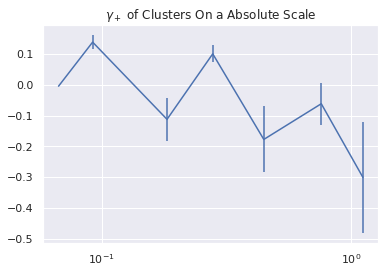

Aggregated xi:
[ 0.      0.      0.      0.0048 -1.1023  0.8972 -0.4993  3.8995  1.7275
  1.8001]
------------------------------------------------------------------------------
Aggregated meanlogr:
[  0.       0.       0.      -2.6983 -19.0744 -13.5932  -6.3902 -17.7692
  -7.7939   0.6306]
------------------------------------------------------------------------------
Aggregated npairs:
[ 0.  0.  0.  1.  8.  8.  5. 22. 28.  6.]
------------------------------------------------------------------------------
Mean xi:
[    nan     nan     nan  0.0048 -0.1378  0.1121 -0.0999  0.1772  0.0617
  0.3   ]
------------------------------------------------------------------------------
Mean meanlogr:
[    nan     nan     nan -2.6983 -2.3843 -1.6992 -1.278  -0.8077 -0.2784
  0.1051]
------------------------------------------------------------------------------


In [30]:
plt_w_error(mean_abs[1],-mean_abs[0],sig_abs,r"$\gamma_+$ of Clusters On a Absolute Scale ")
print_data(sum_abs,mean_abs)

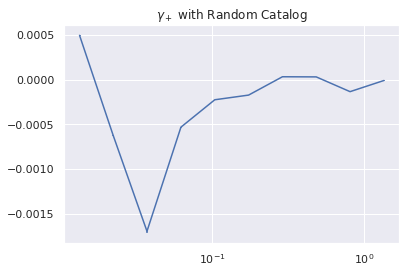

[ 4.9332e-04 -6.2438e-04 -1.6901e-03 -5.3002e-04 -2.2471e-04 -1.7261e-04
  3.1751e-05  3.0225e-05 -1.3427e-04 -1.0015e-05]
[-4.4173e-06  5.5909e-06  1.5134e-05  4.7459e-06  2.0121e-06  1.5456e-06
 -2.8431e-07 -2.7065e-07  1.2023e-06  8.9676e-08]


In [31]:
plt_w_error(r_meanlogr,-r_xi,r_sigma,r"$\gamma_+$ with Random Catalog")
print(-r_xi)
print(r_sigma)

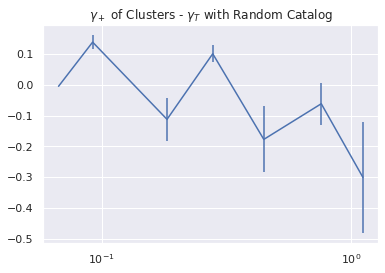

In [32]:
plt_w_error(mean_abs[1],-(mean_abs[0]+r_xi),np.hypot(r_sigma,sig_abs),r"$\gamma_+$ of Clusters - $\gamma_T$ with Random Catalog")

# Rel plots

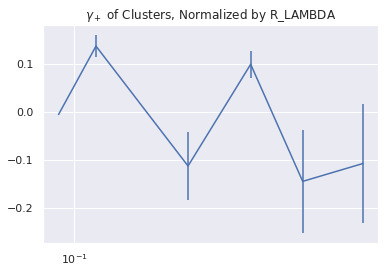

Aggregated xi:
[ 0.      0.      0.      0.      0.0048 -1.1023  0.8972 -0.4993  2.8844
  2.5674]
------------------------------------------------------------------------------
Aggregated meanlogr:
[  0.       0.       0.       0.      -2.4203 -17.0965 -11.5284  -4.8363
 -11.4769  -2.8437]
------------------------------------------------------------------------------
Aggregated npairs:
[ 0.  0.  0.  0.  1.  8.  8.  5. 20. 24.]
------------------------------------------------------------------------------
Mean xi:
[    nan     nan     nan     nan  0.0048 -0.1378  0.1121 -0.0999  0.1442
  0.107 ]
------------------------------------------------------------------------------
Mean meanlogr:
[    nan     nan     nan     nan -2.4203 -2.1371 -1.441  -0.9673 -0.5738
 -0.1185]
------------------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

In [33]:
plt_w_error(mean_rel[1],-mean_rel[0],sig_rel,r"$\gamma_+$ of Clusters, Normalized by R_LAMBDA")
print_data(sum_rel,mean_rel)